In [1]:
import pandas as pd
import numpy as np
import altair as alt
df = pd.read_csv("StudyEventTimeSeries.csv")

In [2]:
codelist = list(set(df.as_matrix().flatten()))
codelist.remove(np.nan)

actionOnly= list(filter(lambda x: x.isupper(),codelist))
featureOnly= list(filter(lambda x: x.islower(),codelist))

/Users/dorislee/.virtualenvs/py37env/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [3]:
# df["t"]=df.index

In [4]:
df = df.stack().reset_index()

df = df.rename(columns={
    "level_0":"t",
    "level_1":"user",
    0:"action"
})

In [5]:
component_dict = {
     'pattern-upload':'Pattern Specification',
     'sketch-to-modify':'Pattern Specification',
     'drag-and-drop':'Result Querying',
     'change-metric':'Match Specification',
     'filter':'Slice-and-Dice',
     'brush-xrange':'Match Specification',
     'min-similarity-cutoff':'Match Specification',
     'smoothing':'Match Specification',
     'ignore-xrange':'Match Specification',
     'representative-outlier':'Recommendation',
     'dynamic-class':'Slice-and-Dice',
     'sketch-to-query':'Pattern Specification',
     'reverse-y':'View Specification',
     'input-equation':'Pattern Specification',
     'upload-dataset':'Pattern Specification',
     'show-scatter':'View Specification',
     'export':'others',
     'change-number-of-results':'Match Specification',
     'control-kmeans-clustersize':'Recommendation',
     'change-axis':'View Specification'
}

In [6]:
df_feature = df[df.action.isin(featureOnly)]
#Remove Export
df_feature = df_feature[df_feature["action"]!="export"]
df_feature["Feature"] = df_feature["action"]
df_component = df_feature
df_component["action"] = df_feature["action"].replace(component_dict)
df_component= df_component.rename(index=str,columns={"action":"component"})

In [7]:
td = 'top-down-querying'
sc = 'search-with-context'
bu = 'bottom-up-querying'
rec= 'recommendation'
component_to_process = {
    'Pattern Specification':td,
    'Match Specification':td,
    'View Specification':sc, 
    'Slice-and-Dice':sc,
    'Result Querying':bu,
    'Recommendation':bu
}

In [8]:
df_process = df_component
df_process["Process"] = df_component["component"].replace(component_to_process)

In [9]:
df_process.loc[df_process["Process"]=="top-down-querying","State"]=0
df_process.loc[df_process["Process"]=="search-with-context","State"]=1
df_process.loc[df_process["Process"]=="bottom-up-querying","State"]=2
df_process["State"] = df_process["State"].astype(int)

In [10]:
#all_users_actions consist of the event seqeunces of every single user for that subject area, separated by list of lists:
# [[1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0],
#  [1, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 1, 2, 2, 0, 1, 1, 0, 2, 0],
#  [2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0]]
def transition_matrix(all_users_actions,type="normalize"):
    n = 3
    M = [[0]*n for _ in range(n)]
    for transitions in all_users_actions:
#         print (transitions)
        if len(transitions)==1:
            M[transitions[0]][transitions[0]]+=1
            #print ("single")
        else:
            for (i,j) in zip(transitions,transitions[1:]):
                M[i][j] += 1
#                 print ("added to {},{}".format(i,j))
    #now convert to probabilities:
    if type=="normalize":
        for row in M:
            s = sum(row)
            if s > 0:
                row[:] = [f/s for f in row]
    return np.array(M)

In [11]:
import networkx as nx
import matplotlib.pyplot as plt
import pydot
from networkx.drawing.nx_pydot import write_dot
import os

In [12]:
def create_graph_viz_from_transition_matrix(Q,subject):
    G= nx.DiGraph(directed=True)
    states = [0,1,2]
    G.add_nodes_from(states)

    edge_labels={}
    for i in range(len(states)):
        for j in range(len(states)):
            prob = Q[i][j]
            if prob > 0:
                G.add_edge(i,
                           j,
                           weight=prob,
                           label="{:.02g}".format(prob))
                edge_labels[(i,j)] = label="{:.02g}".format(prob)


#     plt.subplot(121)
#     limits=plt.axis('off')
# #     nx.draw_networkx(G, with_labels=True, arrows=True,font_weight='bold',node_color='#aacbff')
#     pos = nx.spring_layout(G)
#     nx.draw_networkx_edges(G,pos,width=1.0,alpha=0.5)
#     nx.draw_networkx_labels(G, pos, font_weight=2)
#     nx.draw_networkx_edge_labels(G, pos, edge_labels)
    G = nx.relabel_nodes(G, {0: 'top-down', 1: 'context creation', 2: 'bottom-up'})
    write_dot(G,subject+'.dot')
    os.system("neato -Tps -Goverlap=scale -Elen=3 {0}.dot -o {0}.ps; convert {0}.ps {0}.png".format(subject))
    return G

In [13]:
subject_code= "A"
user_seq= list(df_process[df_process["user"]==subject_code+"1"]["State"])
user_seq2= list(df_process[df_process["user"]==subject_code+"2"]["State"])
user_seq3= list(df_process[df_process["user"]==subject_code+"3"]["State"])

all_users_for_subject=[user_seq,user_seq2,user_seq3]
Q = transition_matrix(all_users_for_subject)
create_graph_viz_from_transition_matrix(Q,"astro")

In [14]:
subject_code= "G"
user_seq= list(df_process[df_process["user"]==subject_code+"1"]["State"])
user_seq2= list(df_process[df_process["user"]==subject_code+"2"]["State"])
user_seq3= list(df_process[df_process["user"]==subject_code+"3"]["State"])

all_users_for_subject=[user_seq,user_seq2,user_seq3]
Q = transition_matrix(all_users_for_subject)
create_graph_viz_from_transition_matrix(Q,"genetics")

In [15]:
subject_code= "M"
user_seq= list(df_process[df_process["user"]==subject_code+"1"]["State"])
user_seq2= list(df_process[df_process["user"]==subject_code+"2"]["State"])
user_seq3= list(df_process[df_process["user"]==subject_code+"3"]["State"])

all_users_for_subject=[user_seq,user_seq2,user_seq3]
Q = transition_matrix(all_users_for_subject)
create_graph_viz_from_transition_matrix(Q,"matsci")

# Including Session-based Breaks

In [16]:
df = pd.read_csv("StudyEventTimeSeries.csv")
df = df.stack().reset_index()

df = df.rename(columns={
    "level_0":"t",
    "level_1":"user",
    0:"action"
})

# df_break = df[df.action.isin(["BR"])]

In [17]:
eventOnly = featureOnly+["BR"]

In [18]:
df_feature = df[df.action.isin(eventOnly)]
#Remove Export
df_feature = df_feature[df_feature["action"]!="export"]
df_feature["Feature"] = df_feature["action"]
df_component = df_feature
df_component["action"] = df_feature["action"].replace(component_dict)
df_component= df_component.rename(index=str,columns={"action":"component"})

In [19]:
df_process = df_component
df_process["Process"] = df_component["component"].replace(component_to_process)

In [20]:
df_process.loc[df_process["Process"]=="top-down-querying","State"]=0
df_process.loc[df_process["Process"]=="search-with-context","State"]=1
df_process.loc[df_process["Process"]=="bottom-up-querying","State"]=2
df_process.loc[df_process["Process"]=="BR","State"]=3
df_process["State"] = df_process["State"].astype(int)

In [21]:
import itertools
def isplit(iterable,splitters):
    return [list(g) for k,g in itertools.groupby(iterable,lambda x:x in splitters) if not k]

In [22]:
subject_code= "G"
user_seq= isplit(list(df_process[df_process["user"]==subject_code+"1"]["State"]),(3,))
user_seq2= isplit(list(df_process[df_process["user"]==subject_code+"2"]["State"]),(3,))
user_seq3= isplit(list(df_process[df_process["user"]==subject_code+"3"]["State"]),(3,))
all_users_for_subject = user_seq+user_seq2+user_seq3
Q = transition_matrix(all_users_for_subject)
G = create_graph_viz_from_transition_matrix(Q,"genetics_break")
print ("Pagerank:",nx.pagerank(G))

Pagerank: {'top-down': 0.298048481692894, 'context creation': 0.24602118426376618, 'bottom-up': 0.4559303340433396}


In [23]:
subject_code= "M"
user_seq= isplit(list(df_process[df_process["user"]==subject_code+"1"]["State"]),(3,))
user_seq2= isplit(list(df_process[df_process["user"]==subject_code+"2"]["State"]),(3,))
user_seq3= isplit(list(df_process[df_process["user"]==subject_code+"3"]["State"]),(3,))
all_users_for_subject = user_seq+user_seq2+user_seq3
Q = transition_matrix(all_users_for_subject)
subject = "matsci_break"
G = create_graph_viz_from_transition_matrix(Q,subject)
print ("Pagerank:",nx.pagerank(G))

Pagerank: {'top-down': 0.26673299633778347, 'context creation': 0.5171331426324091, 'bottom-up': 0.21613386102980753}


In [24]:
subject_code= "A"
user_seq= isplit(list(df_process[df_process["user"]==subject_code+"1"]["State"]),(3,))
user_seq2= isplit(list(df_process[df_process["user"]==subject_code+"2"]["State"]),(3,))
user_seq3= isplit(list(df_process[df_process["user"]==subject_code+"3"]["State"]),(3,))
all_users_for_subject = user_seq+user_seq2+user_seq3
Q = transition_matrix(all_users_for_subject)
subject = "astro_break"
G = create_graph_viz_from_transition_matrix(Q,subject)
print ("Pagerank:",nx.pagerank(G))

Pagerank: {'top-down': 0.4353668588331403, 'context creation': 0.37268509586932314, 'bottom-up': 0.19194804529753645}


### Unnormalized edges as raw counts 

In [25]:
pgrk_lst = []

In [26]:
subject_code= "G"
user_seq= isplit(list(df_process[df_process["user"]==subject_code+"1"]["State"]),(3,))
user_seq2= isplit(list(df_process[df_process["user"]==subject_code+"2"]["State"]),(3,))
user_seq3= isplit(list(df_process[df_process["user"]==subject_code+"3"]["State"]),(3,))
all_users_for_subject = user_seq+user_seq2+user_seq3
Q = transition_matrix(all_users_for_subject,"unnormalize")
G = create_graph_viz_from_transition_matrix(Q,"genetics_break_unnormalized")
print ("Pagerank:",nx.pagerank(G))
pgrk = nx.pagerank(G)
for key in pgrk.keys():
    pgrk_lst.append([key,pgrk[key],"genetics"])

Pagerank: {'top-down': 0.298048481692894, 'context creation': 0.24602118426376618, 'bottom-up': 0.4559303340433396}


In [27]:
subject_code= "M"
user_seq= isplit(list(df_process[df_process["user"]==subject_code+"1"]["State"]),(3,))
user_seq2= isplit(list(df_process[df_process["user"]==subject_code+"2"]["State"]),(3,))
user_seq3= isplit(list(df_process[df_process["user"]==subject_code+"3"]["State"]),(3,))
all_users_for_subject = user_seq+user_seq2+user_seq3
Q = transition_matrix(all_users_for_subject,"unnormalize")
G = create_graph_viz_from_transition_matrix(Q,"matsci_break_unnormalized")
print ("Pagerank:",nx.pagerank(G))
pgrk = nx.pagerank(G)
for key in pgrk.keys():
    pgrk_lst.append([key,pgrk[key],"matsci"])

Pagerank: {'top-down': 0.2667329963377834, 'context creation': 0.5171331426324087, 'bottom-up': 0.21613386102980747}


In [28]:
subject_code= "A"
user_seq= isplit(list(df_process[df_process["user"]==subject_code+"1"]["State"]),(3,))
user_seq2= isplit(list(df_process[df_process["user"]==subject_code+"2"]["State"]),(3,))
user_seq3= isplit(list(df_process[df_process["user"]==subject_code+"3"]["State"]),(3,))
all_users_for_subject = user_seq+user_seq2+user_seq3
Q = transition_matrix(all_users_for_subject,"unnormalized")
G = create_graph_viz_from_transition_matrix(Q,"astro_break_unnormalized")
print ("Pagerank:",nx.pagerank(G))
pgrk = nx.pagerank(G)
for key in pgrk.keys():
    pgrk_lst.append([key,pgrk[key],"astro"])

Pagerank: {'top-down': 0.4353668588331403, 'context creation': 0.37268509586932314, 'bottom-up': 0.19194804529753645}


In [30]:
pgrk_df = pd.DataFrame(pgrk_lst,columns=["Process","PageRankScore","Subject"])

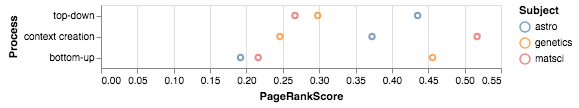

In [34]:
alt.Chart(pgrk_df).mark_point().encode(
    alt.Y("Process",sort=[td,sc,bu]),
    alt.X("PageRankScore"),
    alt.Color("Subject")
)

# For every single user

In [42]:
df_process['subject'] = df_process['user'].apply(lambda x: {'A':'astro', 'G':'genetics', 'M':'material science'}[x[0]])

In [56]:
pgrk_lst  = []
for user in df_process.user.unique():
    selected_tuple = df_process[df_process["user"]==user]
    user_seq= isplit(list(selected_tuple["State"]),(3,))
    Q = transition_matrix(user_seq,"unnormalized")
    G = create_graph_viz_from_transition_matrix(Q,user)
    pgrk = nx.pagerank(G)
    #pgrk_lst.append(list(pgrk.values()))
    print (user, " Pagerank:",pgrk)
    for key in pgrk.keys():
        pgrk_lst.append([user,key,pgrk[key],selected_tuple.iloc[0]["subject"]])
#     plt.plot(pgrk.values(),label=selected_tuple.iloc[0]["subject"])
# plt.legend()

A1  Pagerank: {'top-down': 0.32198589734369654, 'context creation': 0.582966599994722, 'bottom-up': 0.09504750266158155}
A2  Pagerank: {'top-down': 0.26881992120787457, 'context creation': 0.3244636807144889, 'bottom-up': 0.4067163980776362}
A3  Pagerank: {'top-down': 0.5968989758267033, 'context creation': 0.3333333333333333, 'bottom-up': 0.06976769083996354}
G1  Pagerank: {'top-down': 0.6579654654190057, 'context creation': 0.06976744186046513, 'bottom-up': 0.2722670927205292}
G2  Pagerank: {'top-down': 0.10666803460832704, 'context creation': 0.3951915256758482, 'bottom-up': 0.4981404397158246}
M2  Pagerank: {'top-down': 0.331606617251317, 'context creation': 0.3967582065940984, 'bottom-up': 0.2716351761545843}
M3  Pagerank: {'top-down': 0.24101313464046803, 'context creation': 0.41686096002767115, 'bottom-up': 0.34212590533186077}
M1  Pagerank: {'top-down': 0.2248694016527349, 'context creation': 0.5980460223912628, 'bottom-up': 0.17708457595600197}
G3  Pagerank: {'top-down': 0.348

In [61]:
pgrk_df = pd.DataFrame(pgrk_lst,columns=["User","Process","PageRankScore","Subject"])

In [76]:
pgrk_df["UserID"] = pgrk_df["User"].apply(lambda x: x[-1])

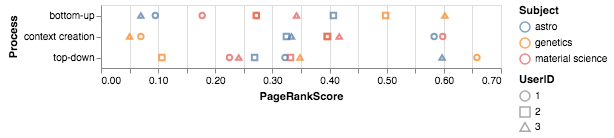

In [80]:
alt.Chart(pgrk_df).mark_point().encode(
    alt.Y("Process"),
    alt.X("PageRankScore"),
    alt.Color("Subject"),
    alt.Shape("UserID")
)

PageRank for individual use graph is unreliable because there aren't a whole lot of nodes and edges, so the scores gets inflated to really high. For example, G1 has a really high top-down , but in fact it only has 1 raw count for top down and 7 for bottom-up. I think self-directed edges doesn't really make sense for PageRank.

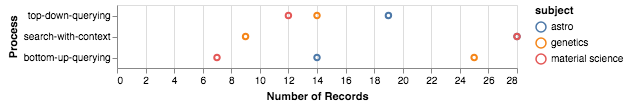

In [93]:
alt.Chart(df_process[df_process["Process"]!="BR"]).mark_point().encode(
    alt.Y("Process",sort=[td,sc,bu]),
    alt.X("t",aggregate="count"),
    alt.Color("subject")
)

In [90]:
df_process[df_process["Process"]!="BR"].groupby(["Process","subject"]).count()["t"]

Process              subject         
bottom-up-querying   astro               14
                     genetics            25
                     material science     7
search-with-context  astro               28
                     genetics             9
                     material science    28
top-down-querying    astro               19
                     genetics            14
                     material science    12
Name: t, dtype: int64

# Component-wise analysis

In [96]:
def component_transition_matrix(all_users_actions,type="normalize"):
    n = 6
    M = [[0]*n for _ in range(n)]
    for transitions in all_users_actions:
#         print (transitions)
        if len(transitions)==1:
            M[transitions[0]][transitions[0]]+=1
            #print ("single")
        else:
            for (i,j) in zip(transitions,transitions[1:]):
                M[i][j] += 1
#                 print ("added to {},{}".format(i,j))
    #now convert to probabilities:
    if type=="normalize":
        for row in M:
            s = sum(row)
            if s > 0:
                row[:] = [f/s for f in row]
    return np.array(M)

In [108]:
def component_create_graph_viz_from_transition_matrix(Q,subject):
    G= nx.DiGraph(directed=True)
    states = range(6)
    G.add_nodes_from(states)

    edge_labels={}
    for i in range(len(states)):
        for j in range(len(states)):
            prob = Q[i][j]
            if prob > 0:
                G.add_edge(i,
                           j,
                           weight=prob,
                           label="{:.02g}".format(prob))
                edge_labels[(i,j)] = label="{:.02g}".format(prob)
    G = nx.relabel_nodes(G, {0: 'Pattern Specification', 1: 'Match Specification', 2: 'View Specification',3:'Slice-and-Dice',4:'Result Querying',5:'Recommendation'})
    write_dot(G,subject+'.dot')
    os.system("neato -Tps -Goverlap=scale -Elen=3 {0}.dot -o {0}.ps; convert {0}.ps {0}.png".format(subject))
    return G

In [109]:
df_component.loc[df_component["component"]=="Pattern Specification","State"]=0
df_component.loc[df_component["component"]=="Match Specification","State"]=1
df_component.loc[df_component["component"]=="View Specification","State"]=2
df_component.loc[df_component["component"]=="Slice-and-Dice","State"]=3
df_component.loc[df_component["component"]=="Result Querying","State"]=4
df_component.loc[df_component["component"]=="Recommendation","State"]=5
df_process.loc[df_process["Process"]=="BR","State"]=-1
df_process["State"] = df_process["State"].astype(int)

In [110]:
subject_code= "A"
user_seq= isplit(list(df_component[df_component["user"]==subject_code+"1"]["State"]),(-1,))
user_seq2= isplit(list(df_component[df_component["user"]==subject_code+"2"]["State"]),(-1,))
user_seq3= isplit(list(df_component[df_component["user"]==subject_code+"3"]["State"]),(-1,))
all_users_for_subject = user_seq+user_seq2+user_seq3
Q = component_transition_matrix(all_users_for_subject,"unnormalized")
G = component_create_graph_viz_from_transition_matrix(Q,"astro_break_unnormalized_component")
print ("Pagerank:",nx.pagerank(G))

Pagerank: {'Pattern Specification': 0.15064010452853296, 'Match Specification': 0.27965632952539476, 'View Specification': 0.07533361218364384, 'Slice-and-Dice': 0.2898907167899551, 'Result Querying': 0.12150104273182798, 'Recommendation': 0.08297819424064534}


In [111]:
subject_code= "G"
user_seq= isplit(list(df_component[df_component["user"]==subject_code+"1"]["State"]),(-1,))
user_seq2= isplit(list(df_component[df_component["user"]==subject_code+"2"]["State"]),(-1,))
user_seq3= isplit(list(df_component[df_component["user"]==subject_code+"3"]["State"]),(-1,))
all_users_for_subject = user_seq+user_seq2+user_seq3
Q = component_transition_matrix(all_users_for_subject,"unnormalized")
G = component_create_graph_viz_from_transition_matrix(Q,"genetics_break_unnormalized_component")
print ("Pagerank:",nx.pagerank(G))

Pagerank: {'Pattern Specification': 0.09529307850342421, 'Match Specification': 0.18287545054084006, 'View Specification': 0.043478589270047115, 'Slice-and-Dice': 0.18970628367834305, 'Result Querying': 0.15247495385493695, 'Recommendation': 0.3361716441524086}


In [112]:
subject_code= "M"
user_seq= isplit(list(df_component[df_component["user"]==subject_code+"1"]["State"]),(-1,))
user_seq2= isplit(list(df_component[df_component["user"]==subject_code+"2"]["State"]),(-1,))
user_seq3= isplit(list(df_component[df_component["user"]==subject_code+"3"]["State"]),(-1,))
all_users_for_subject = user_seq+user_seq2+user_seq3
Q = component_transition_matrix(all_users_for_subject,"unnormalized")
G = component_create_graph_viz_from_transition_matrix(Q,"matsci_break_unnormalized_component")

print ("Pagerank:",nx.pagerank(G))

Pagerank: {'Pattern Specification': 0.21213027932026135, 'Match Specification': 0.0732102984522294, 'View Specification': 0.1917631978654886, 'Slice-and-Dice': 0.2990823732711139, 'Result Querying': 0.16028028465449726, 'Recommendation': 0.063533566436409}


In [118]:
subject_code= "A"
user_seq= isplit(list(df_component[df_component["user"]==subject_code+"1"]["State"]),(-1,))
user_seq2= isplit(list(df_component[df_component["user"]==subject_code+"2"]["State"]),(-1,))
user_seq3= isplit(list(df_component[df_component["user"]==subject_code+"3"]["State"]),(-1,))
all_users_for_subject = user_seq+user_seq2+user_seq3
Q = component_transition_matrix(all_users_for_subject)
G = component_create_graph_viz_from_transition_matrix(Q,"astro_break_component")

print ("Pagerank:",nx.pagerank(G))


Pagerank: {'Pattern Specification': 0.150640104528533, 'Match Specification': 0.2796563295253948, 'View Specification': 0.07533361218364384, 'Slice-and-Dice': 0.2898907167899551, 'Result Querying': 0.12150104273182798, 'Recommendation': 0.08297819424064534}


In [117]:

subject_code= "G"
user_seq= isplit(list(df_component[df_component["user"]==subject_code+"1"]["State"]),(-1,))
user_seq2= isplit(list(df_component[df_component["user"]==subject_code+"2"]["State"]),(-1,))
user_seq3= isplit(list(df_component[df_component["user"]==subject_code+"3"]["State"]),(-1,))
all_users_for_subject = user_seq+user_seq2+user_seq3
Q = component_transition_matrix(all_users_for_subject)
G = component_create_graph_viz_from_transition_matrix(Q,"genetics_break_component")
print ("Pagerank:",nx.pagerank(G))

Pagerank: {'Pattern Specification': 0.09529307850342421, 'Match Specification': 0.18287545054084006, 'View Specification': 0.043478589270047115, 'Slice-and-Dice': 0.18970628367834305, 'Result Querying': 0.15247495385493695, 'Recommendation': 0.3361716441524086}


In [116]:
subject_code= "M"
user_seq= isplit(list(df_component[df_component["user"]==subject_code+"1"]["State"]),(-1,))
user_seq2= isplit(list(df_component[df_component["user"]==subject_code+"2"]["State"]),(-1,))
user_seq3= isplit(list(df_component[df_component["user"]==subject_code+"3"]["State"]),(-1,))
all_users_for_subject = user_seq+user_seq2+user_seq3
Q = component_transition_matrix(all_users_for_subject)
G = component_create_graph_viz_from_transition_matrix(Q,"matsci_break_component")

print ("Pagerank:",nx.pagerank(G))

Pagerank: {'Pattern Specification': 0.2121302793202614, 'Match Specification': 0.07321029845222943, 'View Specification': 0.19176319786548868, 'Slice-and-Dice': 0.2990823732711141, 'Result Querying': 0.1602802846544973, 'Recommendation': 0.06353356643640903}
